<p>Ben Trey<br>
Spark Mini-Project: Databricks edition<br>
2019/12/24</p>

<p><b><i>I had trouble signing up so this is the best I could do.</i></b></p>

In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import avg
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
import matplotlib.pyplot as plt
import os

directory = '/mnt/c/users/我的电脑/desktop/springboard/SparkMini-ProjectDatabricksEdition/'

<h1>Exercise Overview</h1>
<p>In this exercise we will play with Spark <a href="https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes">Datasets & Dataframes</a>, some <a href="https://spark.apache.org/docs/latest/sql-programming-guide.html#sql">Spark SQL</a>, and build a couple of binary classifiaction models using <a href="https://spark.apache.org/docs/latest/ml-guide.html">Spark ML</a> (with some <a href="https://spark.apache.org/mllib/">MLlib</a> too).

The set up and approach will not be too dissimilar to the standard type of approach you might do in <a href="http://scikit-learn.org/stable/index.html">Sklearn</a>. Spark has matured to the stage now where for 90% of what you need to do (when analysing tabular data) should be possible with Spark dataframes, SQL, and ML libraries. This is where this exercise is mainly trying to focus.

Feel free to adapt this exercise to play with other datasets readily availabe in the Databricks enviornment (they are listed in a cell below).

<b>Getting Started</b><br>
To get started you will need to create and attach a databricks spark cluster to this notebook. This notebook was developed on a cluster created with:<br>
-Databricks Runtime Version 4.0 (includes Apache Spark 2.3.0, Scala 2.11)<br>
-Python Version 3<br><br>
<b>Links & References</b><br>
Some useful links and references of sources used in creating this exercise:

<b>Note</b>: Right click and open as new tab!

&nbsp;&nbsp;1. <a href="https://spark.apache.org/docs/latest/index.html">Latest Spark Docs</a><br>
&nbsp;&nbsp;2. <a href="https://databricks.com/">Databricks Homepage</a><br>
&nbsp;&nbsp;3. <a href="https://databricks.com/product/faq/community-edition">Databricks Community Edition FAQ</a><br>
&nbsp;&nbsp;4. <a href="https://databricks.com/training-overview/training-self-paced">Databricks Self Paced Training</a><br>
&nbsp;&nbsp;5. <a href="https://docs.databricks.com/user-guide/notebooks/index.html">Databricks Notebook Guide</a><br>
&nbsp;&nbsp;6. <a href="https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html#binary-classification">Databricks Binary Classification Tutorial</a></p>

<h1>Get Data</h1>
<p>Here we will pull in some sample data that is already pre-loaded onto all databricks clusters.

Feel free to adapt this notebook later to play around with a different dataset if you like (all available are listed in a cell below).</p>

In [2]:
# display datasets already in databricks
pd.read_csv(directory+'datasets.csv').head()

,path,name,size
0,dbfs:/databricks-datasets/README.md,README.md,976
1,dbfs:/databricks-datasets/Rdatasets/,Rdatasets/,0
2,dbfs:/databricks-datasets/SPARK_README.md,SPARK_README.md,3359
3,dbfs:/databricks-datasets/adult/,adult/,0
4,dbfs:/databricks-datasets/airlines/,airlines/,0


<p>Lets take a look at the 'adult' dataset on the filesystem. This is the typical US Census data you often see online in tutorials. <a href="https://archive.ics.uci.edu/ml/datasets/adult">Here</a> is the same data in the UCI repository.

As an aside: <a href="https://github.com/GoogleCloudPlatform/cloudml-samples/tree/master/census">here</a> this same dataset is used as a quickstart example for Google CLoud ML & Tensorflow Estimator API (in case youd be interested in playing with tensorflow on the same dataset as here).</p>

In [3]:
#fs ls databricks-datasets/adult/adult.data
pd.read_csv(directory+'datasets1.csv').head()

,path,name,size
0,dbfs:/databricks-datasets/adult/adult.data,adult.data,3974305


Note: Above %fs is just some file system cell magic that is specific to databricks. More info <a href="https://docs.databricks.com/user-guide/notebooks/index.html#mix-languages">here</a>.

<h1>Spark SQL</h1>
<p>Below we will use Spark SQL to load in the data and then register it as a Dataframe aswell. So the end result will be a Spark SQL table called adult and a Spark Dataframe called df_adult.

This is an example of the flexibility in Spark in that you could do lots of you ETL and data wrangling using either Spark SQL or Dataframes and pyspark. Most of the time it's a case of using whatever you are most comfortable with.

When you get more advanced then you might looking the pro's and con's of each and when you might favour one or the other (or operating direclty on RDD's), <a href="https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html">here</a> is a good article on the issues. For now, no need to overthink it!</p>

%sql <br>
-- drop the table if it already exists<br>
<b>DROP TABLE IF EXISTS</b> adult<br>
OK<br>

%sql<br>
-- create a new table in Spark SQL from the datasets already loaded in the underlying filesystem.<br>
-- In the real world you might be pointing at a file on HDFS or a hive table etc.<br> 
<b>CREATE TABLE</b> adult (<br>
&nbsp;&nbsp;age DOUBLE,<br>
&nbsp;&nbsp;workclass STRING,<br>
&nbsp;&nbsp;fnlwgt DOUBLE,<br>
&nbsp;&nbsp;education STRING,<br>
&nbsp;&nbsp;education_num DOUBLE,<br>
&nbsp;&nbsp;marital_status STRING,<br>
&nbsp;&nbsp;occupation STRING,<br>
&nbsp;&nbsp;relationship STRING,<br>
&nbsp;&nbsp;race STRING,<br>
&nbsp;&nbsp;sex STRING,<br>
&nbsp;&nbsp;capital_gain DOUBLE,<br>
&nbsp;&nbsp;capital_loss DOUBLE,<br>
&nbsp;&nbsp;hours_per_week DOUBLE,<br>
&nbsp;&nbsp;native_country STRING,<br>
&nbsp;&nbsp;income STRING)<br>
<b>USING</b> com.databricks.spark.csv<br>
<b>OPTIONS</b> (path "/databricks-datasets/adult/adult.data", header "true")<br>
OK

In [4]:
#spark test
!SPARK_LOCAL_IP=127.0.0.1 /home/bentrey/spark/spark-3.0.0-preview-bin-hadoop2.7/bin/spark-shell --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.0.0-preview
      /_/
                        
Using Scala version 2.12.10, OpenJDK 64-Bit Server VM, 1.8.0_232
Branch HEAD
Compiled by user ubuntu on 2019-10-31T01:29:07Z
Revision 007c873ae34f58651481ccba30e8e2ba38a692c4
Url https://gitbox.apache.org/repos/asf/spark.git
Type --help for more information.


In [5]:
!SPARK_LOCAL_IP=127.0.0.1

In [6]:
# look at the data
#spark.sql("SELECT * FROM adult LIMIT 5").show() 
# this will look prettier in Databricks if you use display() instead
spark = SparkSession.builder.appName('adult').config('spark.driver.bindAddress','127.0.0.1').getOrCreate()

In [7]:
df = spark.read.csv(directory+'adult.csv',inferSchema=True,header=True)

In [8]:
#spark.sql("DROP TABLE adult")
spark.sql("""CREATE TABLE adult (
  age DOUBLE,
  workclass STRING,
  fnlwgt DOUBLE,
  education STRING,
  education_num DOUBLE,
  marital_status STRING,
  occupation STRING,
  relationship STRING,
  race STRING,
  sex STRING,
  capital_gain DOUBLE,
  capital_loss DOUBLE,
  hours_per_week DOUBLE,
  native_country STRING,
  income STRING)
  USING com.databricks.spark.csv
  OPTIONS (path "/mnt/c/users/我的电脑/desktop/springboard/SparkMini-ProjectDatabricksEdition/adult.data", header="true")""")

DataFrame[]

In [9]:
# look at the data
#spark.sql("SELECT * FROM adult LIMIT 5").show() 
# this will look prettier in Databricks if you use display() in
spark.sql("SELECT * FROM adult LIMIT 5").toPandas()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
1,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
2,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
3,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
4,37.0,Private,284582.0,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K


<p>If you are more comfortable with SQL then as you can see below, its very easy to just get going with writing standard SQL type code to analyse your data, do data wrangling and create new dataframes.</p>

In [10]:
# Lets get some summary marital status rates by occupation
result = spark.sql(
  """
  SELECT 
    occupation,
    SUM(1) as n,
    ROUND(AVG(if(LTRIM(marital_status) LIKE 'Married-%',1,0)),2) as married_rate,
    ROUND(AVG(if(lower(marital_status) LIKE '%widow%',1,0)),2) as widow_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Divorced',1,0)),2) as divorce_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Separated',1,0)),2) as separated_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM 
    adult 
  GROUP BY 1
  ORDER BY n DESC
  """)
result.toPandas()

,occupation,n,married_rate,widow_rate,divorce_rate,separated_rate,bachelor_rate
0,Prof-specialty,4140,0.53,0.02,0.13,0.02,0.30
1,Craft-repair,4099,0.64,0.01,0.11,0.03,0.21
2,Exec-managerial,4066,0.61,0.02,0.15,0.02,0.20
3,Adm-clerical,3769,0.28,0.04,0.22,0.04,0.42
4,Sales,3650,0.47,0.03,0.12,0.03,0.36
5,Other-service,3295,0.24,0.05,0.15,0.06,0.50
6,Machine-op-inspct,2002,0.51,0.03,0.14,0.04,0.29
7,?,1843,0.36,0.08,0.10,0.04,0.42
8,Transport-moving,1597,0.63,0.02,0.11,0.02,0.21
9,Handlers-cleaners,1370,0.36,0.01,0.09,0.03,0.51


<p>You can easily register dataframes as a table for Spark SQL too. So this way you can easily move between Dataframes and Spark SQL for whatever reason.</p>

In [11]:
SQLContext.registerDataFrameAsTable(result, df=result, tableName="result")
spark.sql("SELECT * FROM result").toPandas().head(5)

,occupation,n,married_rate,widow_rate,divorce_rate,separated_rate,bachelor_rate
0,Prof-specialty,4140,0.53,0.02,0.13,0.02,0.30
1,Craft-repair,4099,0.64,0.01,0.11,0.03,0.21
2,Exec-managerial,4066,0.61,0.02,0.15,0.02,0.20
3,Adm-clerical,3769,0.28,0.04,0.22,0.04,0.42
4,Sales,3650,0.47,0.03,0.12,0.03,0.36


<h1>Question 1</h1>
<p>1. Write some spark sql to get the top 'bachelor_rate' by 'education' group.

In [12]:
spark.sql(
"""
  SELECT 
    education,
    SUM(1) as n,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM 
    adult 
  GROUP BY 1
  ORDER BY bachelor_rate DESC
  """).toPandas()

,education,n,bachelor_rate
0,12th,433,0.54
1,11th,1175,0.50
2,Preschool,51,0.43
3,Some-college,7291,0.40
4,10th,933,0.39
5,Bachelors,5354,0.34
6,Assoc-acdm,1067,0.32
7,9th,514,0.30
8,HS-grad,10501,0.29
9,5th-6th,333,0.27


<h1>Spark DataFrames</h1>
<p>Below we will create our DataFrame from the SQL table and do some similar analysis as we did with Spark SQL but using the DataFrames API.</p>

In [13]:
# register a df from the sql df
df_adult = spark.table("adult")
cols = df_adult.columns 
# this will be used much later in the notebook, ignore for now

In [14]:
# look at df schema
df_adult.printSchema()

root
 |-- age: double (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [15]:
# look at the df
df_adult.show(5)

+----+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| age|        workclass|  fnlwgt| education|education_num|     marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+----+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|50.0| Self-emp-not-inc| 83311.0| Bachelors|         13.0| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|         0.0|         0.0|          13.0| United-States| <=50K|
|38.0|          Private|215646.0|   HS-grad|          9.0|           Divorced| Handlers-cleaners| Not-in-family| White|   Male|         0.0|         0.0|          40.0| United-States| <=50K|
|53.0|          Private|234721.0|      11th| 

<p>
Below we will do a similar calculation to what we did above but using the DataFrames API</p>

In [16]:
# import what we will need
from pyspark.sql.functions import when, col, mean, desc, round

# wrangle the data a bit
df_result = df_adult.select(
  df_adult['occupation'], 
  # create a 1/0 type col on the fly
  when( col('marital_status') == ' Divorced' , 1 ).otherwise(0).alias('is_divorced')
)
# do grouping (and a round)
df_result = df_result.groupBy('occupation').agg(round(mean('is_divorced'),2).alias('divorced_rate'))
# do ordering
df_result = df_result.orderBy(desc('divorced_rate'))
# show results
df_result.show(5)

+----------------+-------------+
|      occupation|divorced_rate|
+----------------+-------------+
|    Adm-clerical|         0.22|
| Priv-house-serv|         0.19|
|    Tech-support|         0.15|
|   Other-service|         0.15|
| Exec-managerial|         0.15|
+----------------+-------------+
only showing top 5 rows



<p>As you can see the dataframes api is a bit more verbose then just expressing what you want to do in standard SQL.

But some prefer it and might be more used to it, and there could be cases where expressing what you need to do might just be better using the DataFrame API if it is too complicated for a simple SQL expression for example of maybe involves recursion of some type.</p>

<h1>Question 2</h1>
<p>1. Write some pyspark to get the top 'bachelor_rate' by 'education' group using DataFrame operations.</p>

In [17]:
# wrangle the data a bit
df_result = df_adult.select(
  df_adult['education'], 
  # create a 1/0 type col on the fly
  when( col('marital_status') == ' Never-married' , 1 ).otherwise(0).alias('is_single')
)
# do grouping (and a round)
df_result = df_result.groupBy('education').agg(round(mean('is_single'),2).alias('bachelor_rate'))
# do ordering
df_result = df_result.orderBy(desc('bachelor_rate'))
# show results
df_result.show(5)

+-------------+-------------+
|    education|bachelor_rate|
+-------------+-------------+
|         12th|         0.54|
|         11th|          0.5|
|    Preschool|         0.43|
| Some-college|          0.4|
|         10th|         0.39|
+-------------+-------------+
only showing top 5 rows



<h1>Explore & Visualize Data</h1>
<p>It's very easy to <a href="https://spark.apache.org/docs/latest/rdd-programming-guide.html#printing-elements-of-an-rdd">collect()</a> your Spark DataFrame data into a Pandas df and then continue to analyse or plot as you might normally.

Obviously if you try to collect() a huge DataFrame then you will run into issues, so usually you would only collect aggregated or sampled data into a Pandas df.</p>

In [18]:
# do some analysis
result = spark.sql(
  """
  SELECT 
    occupation,
    AVG(IF(income = ' >50K',1,0)) as plus_50k
  FROM 
    adult 
  GROUP BY 1
  ORDER BY 2 DESC
  """)

# collect results into a pandas df
df_pandas = pd.DataFrame(
  result.collect(),
  columns=result.schema.names
)

# look at df
print(df_pandas.head())

         occupation  plus_50k
0   Exec-managerial  0.484014
1    Prof-specialty  0.449034
2   Protective-serv  0.325116
3      Tech-support  0.304957
4             Sales  0.269315


In [19]:
print(df_pandas.describe())

        plus_50k
count  15.000000
mean    0.197357
std     0.143993
min     0.006711
25%     0.107373
50%     0.134518
75%     0.287136
max     0.484014


In [20]:
print(df_pandas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
occupation    15 non-null object
plus_50k      15 non-null float64
dtypes: float64(1), object(1)
memory usage: 320.0+ bytes
None


<p>Here we will just do some very basic plotting to show how you might collect what you are interested in into a Pandas DF and then just plot any way you normally would.

For simplicity we are going to use the plotting functionality built into pandas (you could make this a pretty as you want).</p>

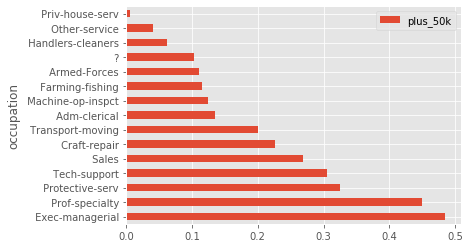

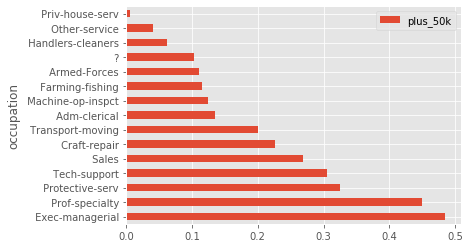

In [21]:
# i like ggplot style
plt.style.use('ggplot')

# get simple plot on the pandas data
myplot = df_pandas.plot(kind='barh', x='occupation', y='plus_50k')

# display the plot (note - display() is a databricks function - 
# more info on plotting in Databricks is here: https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html)
display(myplot.figure)

You can also easily get summary stats on a Spark DataFrame like below. <a href="https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html">Here</a> is a nice blog post that has more examples.

So this is an example of why you might want to move from Spark SQL into DataFrames API as being able to just call describe() on the Spark DF is easier then trying to do the equivilant in Spark SQL.

In [22]:
# describe df
df_adult.select(df_adult['age'],df_adult['education_num']).describe().show()

+-------+------------------+------------------+
|summary|               age|     education_num|
+-------+------------------+------------------+
|  count|             32560|             32560|
|   mean|38.581633906633904| 10.08058968058968|
| stddev|13.640641827464002|2.5727089681052058|
|    min|              17.0|               1.0|
|    max|              90.0|              16.0|
+-------+------------------+------------------+



<h1>ML Pipeline - Logistic Regression vs Random Forest</h1>
<p>Below we will create two <a href="https://spark.apache.org/docs/latest/ml-pipeline.html">Spark ML Pipelines</a> - one that fits a logistic regression and one that fits a random forest. We will then compare the performance of each.

    Note: A lot of the code below is adapted from <a href="https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html">this example</a>.</p>

In [23]:
categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
stages = [] # stages in our Pipeline

for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]


In [24]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]

In [25]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [26]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)
# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
pipelineModel = pipeline.fit(df_adult)
dataset = pipelineModel.transform(df_adult)
# Keep relevant columns
selectedcols = ["label", "features"] + cols
dataset = dataset.select(selectedcols)
dataset

DataFrame[label: double, features: vector, age: double, workclass: string, fnlwgt: double, education: string, education_num: double, marital_status: string, occupation: string, relationship: string, race: string, sex: string, capital_gain: double, capital_loss: double, hours_per_week: double, native_country: string, income: string]

In [27]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

22831
9729


In [28]:
# get the rate of the positive outcome from the training data to use as a threshold in the model
training_data_positive_rate = trainingData.select(avg(trainingData['label'])).collect()[0][0] 

print("Positive rate in the training data is {}".format(training_data_positive_rate))

Positive rate in the training data is 0.2398931277648811


<h1>Logistic Regression - Train</h1>

In [29]:
# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# set threshold for the probability above which to predict a 1
lr.setThreshold(training_data_positive_rate)
# lr.setThreshold(0.5) # could use this if knew you had balanced data

# Train model with Training Data
lrModel = lr.fit(trainingData)

# get training summary used for eval metrics and other params
lrTrainingSummary = lrModel.summary

# Find the best model threshold if you would like to use that instead of the empirical positve rate
fMeasure = lrTrainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
lrBestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
  
print("Best threshold based on model performance on training data is {}".format(lrBestThreshold))

Best threshold based on model performance on training data is 0.38202797831794244


<h1>GBM - Train</h1>

<h1>Question 3</h1>
<p>1. Train a GBTClassifier on the training data, call the trained model 'gbModel'</p>

In [30]:
gb = GBTClassifier()
gbModel = gb.fit(trainingData)

<h1>Logistic Regression -Predict</h1>

In [31]:
# make predictions on test data
lrPredictions = lrModel.transform(testData)

# display predictions
#display(lrPredictions.select("label", "prediction", "probability"))
#display(lrPredictions)
df = lrPredictions.toPandas()
df.drop(df.columns.difference(['label','prediction','probability']), 1, inplace=True)
df

,label,probability,prediction
0,0.0,"[0.15558714514333502, 0.844412854856665]",1.0
1,0.0,"[0.6978787145962698, 0.30212128540373023]",1.0
2,0.0,"[0.4893632261826197, 0.5106367738173804]",1.0
3,0.0,"[0.6787721431468237, 0.3212278568531763]",1.0
4,0.0,"[0.6057264047792347, 0.3942735952207653]",1.0
5,0.0,"[0.6063582358168302, 0.3936417641831699]",1.0
6,0.0,"[0.5967673056938726, 0.4032326943061274]",1.0
7,0.0,"[0.5960955533001719, 0.40390444669982806]",1.0
8,0.0,"[0.7633298613814143, 0.23667013861858557]",0.0
9,0.0,"[0.9892175014341773, 0.010782498565822751]",0.0


<h1>GBM - Predict</h1>

<h1>Question 4</h1>
<p>1. Get predictions on the test data for your GBTClassifier. Call the predictions df 'gbPredictions'.</p>

In [32]:
# make predictions on test data
gbPredictions = gbModel.transform(testData)

# display predictions
#display(lrPredictions.select("label", "prediction", "probability"))
#display(lrPredictions)
df = gbPredictions.toPandas()
df.drop(df.columns.difference(['label','prediction','probability']), 1, inplace=True)
df

,label,probability,prediction
0,0.0,"[0.2516054850464214, 0.7483945149535787]",1.0
1,0.0,"[0.7453501732757283, 0.2546498267242717]",0.0
2,0.0,"[0.686502192487619, 0.313497807512381]",0.0
3,0.0,"[0.6503163162287169, 0.3496836837712831]",0.0
4,0.0,"[0.6212635895957713, 0.3787364104042287]",0.0
5,0.0,"[0.6119542654663872, 0.3880457345336128]",0.0
6,0.0,"[0.6119542654663872, 0.3880457345336128]",0.0
7,0.0,"[0.7870751891875888, 0.2129248108124112]",0.0
8,0.0,"[0.7170350589422254, 0.2829649410577746]",0.0
9,0.0,"[0.8718959335313619, 0.12810406646863814]",0.0


<h1>Logistic Regression-Evaluate</h1>

<h1>Question 5</h1>
<p>Complete the print_performance_metrics() function below to also include measures of F1, Precision, Recall, False Positive Rate and True Positive Rate.</p>

In [33]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

def print_performance_metrics(predictions):
  # Evaluate model
  evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
  auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
  aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
  print("auc = {}".format(auc))
  print("aupr = {}".format(aupr))

  # get rdd of predictions and labels for mllib eval metrics
  predictionAndLabels = predictions.select("prediction","label").rdd

  # Instantiate metrics objects
  binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
  multi_metrics = MulticlassMetrics(predictionAndLabels)

  # Area under precision-recall curve
  print("Area under PR = {}".format(binary_metrics.areaUnderPR))
  # Area under ROC curve
  print("Area under ROC = {}".format(binary_metrics.areaUnderROC))
  # Accuracy
  print("Accuracy = {}".format(multi_metrics.accuracy))
  # Confusion Matrix
  print(multi_metrics.confusionMatrix())
  
  ### Question 5.1 Answer ###

  # F1
  print("F1 = {}".format(multi_metrics.fMeasure(1.0)))
  # Precision
  print("Precision = {}".format(multi_metrics.precision(1.0)))
  # Recall
  print("Recall = {}".format(multi_metrics.recall(1.0)))
  # FPR
  print("FPR = {}".format(multi_metrics.falsePositiveRate(1.0)))
  # TPR
  print("TPR = {}".format(multi_metrics.truePositiveRate(1.0)))
  
  
print_performance_metrics(lrPredictions)

auc = 0.8989765008735999
aupr = 0.7560532769483124
Area under PR = 0.5358042028702068
Area under ROC = 0.8154134833086935
Accuracy = 0.8014184397163121
DenseMatrix([[5805., 1560.],
             [ 372., 1992.]])
F1 = 0.6734279918864098
Precision = 0.5608108108108109
Recall = 0.8426395939086294
FPR = 0.21181262729124237
TPR = 0.8426395939086294


<h1>GBM - Evaluate</h1>

In [34]:
print_performance_metrics(gbPredictions)

auc = 0.9104732046550253
aupr = 0.7870953211183158
Area under PR = 0.6485518048263849
Area under ROC = 0.7564766473339055
Accuracy = 0.851783328194059
DenseMatrix([[6937.,  428.],
             [1014., 1350.]])
F1 = 0.6518590053114437
Precision = 0.7592800899887514
Recall = 0.5710659898477157
FPR = 0.05811269517990496
TPR = 0.5710659898477157


<h1>Cross Validation</h1>

<p>For each model you can run the below comand to see its params and a brief explanation of each.</p>

In [35]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [36]:
print(gb.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

<h1>Logisitic Regression - Param Grid</h1>

In [37]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
lrParamGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [2, 5])
             .build())

<h1>GBM - Param Grid</h1>

<h1>Question 6</h1>
<p>Build out a param grid for the gb model, call it 'gbParamGrid'.</p>

In [38]:
gbParamGrid = (ParamGridBuilder()
             .addGrid(gb.maxIter, [2, 5])
             .build())

<h1>Logistic Regression - Perform Cross Validation</h1>

In [39]:
# set up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create CrossValidator
lrCv = CrossValidator(estimator=lr, estimatorParamMaps=lrParamGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
lrCvModel = lrCv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [40]:
# below approach to getting at the best params from the best cv model taken from:
# https://stackoverflow.com/a/46353730/1919374

# look at best params from the CV
print(lrCvModel.bestModel._java_obj.getRegParam())
print(lrCvModel.bestModel._java_obj.getElasticNetParam())
print(lrCvModel.bestModel._java_obj.getMaxIter())

0.01
0.0
5


<h1>GBM - Perform Cross Validation</h1>

<h1>Question 7</h1>
<p>1. Perform cross validation of params on your 'gb' model.<br>
2. Print out the best params you found.</p>

In [41]:
gbCv=CrossValidator(estimator=gb, estimatorParamMaps=gbParamGrid, evaluator=evaluator, numFolds=2)
gbCvModel=gbCv.fit(trainingData)

In [42]:
print(gbCvModel.bestModel._java_obj.getMaxIter())

5


<h1>Logistic Regression - CV Model Predict</h1>

In [43]:
# Use test set to measure the accuracy of our model on new data
lrCvPredictions = lrCvModel.transform(testData)

lrCvPredictions.toPandas()

,label,features,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,rawPrediction,probability,prediction
0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",36.0,Private,370767.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,2377.0,60.0,United-States,<=50K,"[-0.7777223369999622, 0.7777223369999622]","[0.3148109820664116, 0.6851890179335883]",1.0
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",32.0,Private,131224.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"[0.3346685156915544, -0.3346685156915544]","[0.5828948631530981, 0.41710513684690187]",1.0
2,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",33.0,Private,279173.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,60.0,United-States,<=50K,"[0.34698575633685813, -0.34698575633685813]","[0.5858864423447466, 0.41411355765525343]",1.0
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",39.0,Private,50700.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"[0.24998881415878094, -0.24998881415878094]","[0.5621737476671151, 0.43782625233288486]",1.0
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",39.0,Private,181705.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,45.0,United-States,<=50K,"[0.32692650916338617, -0.32692650916338617]","[0.5810113617989237, 0.4189886382010763]",1.0
5,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",50.0,Private,81548.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"[0.23923852428817183, -0.23923852428817183]","[0.5595259870243148, 0.4404740129756853]",1.0
6,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",51.0,Private,94432.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"[0.24609496715170676, -0.24609496715170676]","[0.5612151070016728, 0.43878489299832724]",1.0
7,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",60.0,Private,198727.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,30.0,United-States,<=50K,"[0.3484950444043632, -0.3484950444043632]","[0.5862525835954653, 0.4137474164045347]",1.0
8,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",34.0,Private,241360.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,?,<=50K,"[0.44339625134920124, -0.44339625134920124]","[0.609067991245724, 0.3909320087542761]",1.0
9,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",20.0,Private,219266.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Own-child,White,Female,0.0,0.0,36.0,?,<=50K,"[1.9709903962363384, -1.9709903962363384]","[0.8777174517077011, 0.12228254829229881]",0.0


<h1>GBM - CV Model Predict</h1>

In [44]:
gbCvPredictions = gbCvModel.transform(testData)

gbCvPredictions.toPandas()

,label,features,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,rawPrediction,probability,prediction
0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",36.0,Private,370767.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,2377.0,60.0,United-States,<=50K,"[-0.5072719041706143, 0.5072719041706143]","[0.26609156220027474, 0.7339084377997253]",1.0
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",32.0,Private,131224.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"[0.4829219919232825, -0.4829219919232825]","[0.7242903410484085, 0.2757096589515915]",0.0
2,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",33.0,Private,279173.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,60.0,United-States,<=50K,"[0.42967059210244213, -0.42967059210244213]","[0.7025229904686546, 0.29747700953134537]",0.0
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",39.0,Private,50700.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"[0.36238400907873325, -0.36238400907873325]","[0.6736561017954683, 0.3263438982045317]",0.0
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",39.0,Private,181705.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,45.0,United-States,<=50K,"[0.3235896426030105, -0.3235896426030105]","[0.656374539824131, 0.34362546017586904]",0.0
5,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",50.0,Private,81548.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"[0.36238400907873325, -0.36238400907873325]","[0.6736561017954683, 0.3263438982045317]",0.0
6,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",51.0,Private,94432.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K,"[0.36238400907873325, -0.36238400907873325]","[0.6736561017954683, 0.3263438982045317]",0.0
7,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",60.0,Private,198727.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,30.0,United-States,<=50K,"[0.4662410874428437, -0.4662410874428437]","[0.7175785935145397, 0.2824214064854603]",0.0
8,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",34.0,Private,241360.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,40.0,?,<=50K,"[0.4304742882375653, -0.4304742882375653]","[0.7028588010494031, 0.2971411989505969]",0.0
9,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",20.0,Private,219266.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Own-child,White,Female,0.0,0.0,36.0,?,<=50K,"[0.5711017894119955, -0.5711017894119955]","[0.7580839889675492, 0.24191601103245075]",0.0


<h1>Logistic Regression - CV Model Evaluate
</h1>

In [45]:
print_performance_metrics(lrCvPredictions)

auc = 0.8831908360643915
aupr = 0.7175268236201614
Area under PR = 0.5055509217301563
Area under ROC = 0.800773051991688
Accuracy = 0.778600061671292
DenseMatrix([[5580., 1785.],
             [ 369., 1995.]])
F1 = 0.6494140625
Precision = 0.5277777777777778
Recall = 0.8439086294416244
FPR = 0.24236252545824846
TPR = 0.8439086294416244


<h1>GBM - CV Model Evaluate</h1>

In [46]:
print_performance_metrics(gbCvPredictions)

auc = 0.9021672105800631
aupr = 0.7720386982376425
Area under PR = 0.6399182600495462
Area under ROC = 0.7270171031183985
Accuracy = 0.8428409908520916
DenseMatrix([[7014.,  351.],
             [1178., 1186.]])
F1 = 0.6080492181491924
Precision = 0.7716330513988289
Recall = 0.5016920473773265
FPR = 0.04765784114052953
TPR = 0.5016920473773265


<h1>Logistic Regression - Model Explore</h1>

In [47]:
print('Model Intercept: ', lrCvModel.bestModel.intercept)

Model Intercept:  -1.2439633691175789


In [48]:
lrWeights = lrCvModel.bestModel.coefficients
lrWeights = [(float(w),) for w in lrWeights]  # convert numpy type to float, and to tuple
pd.DataFrame(lrWeights, columns=["Feature Weight"])

,Feature Weight
0,-2.082637e-01
1,-3.307606e-01
2,-1.568737e-01
3,-4.595653e-01
4,-2.737833e-01
5,4.933277e-01
6,2.806628e-01
7,-1.175171e+00
8,-4.452884e-01
9,-1.885009e-01


<h1>Feature Importance</h1>

<h1>Question 8</h1>
<p>Print out a table of feature_name and feature_coefficient from the Logistic Regression model.

Hint: Adapt the code from here: https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name</p>

In [221]:
#lrPredictions.toPandas()
pretty_df = pd.DataFrame(lrWeights, columns=["Feature Weight"])
pretty_df['label'] = 'null'
for n in range(100):
    pretty_df.at[n,'label'] = list(lrPredictions.schema['features'].metadata["ml_attr"]["attrs"]['binary']+\
                                   lrPredictions.schema['features'].metadata["ml_attr"]["attrs"]['numeric'])[n]['name']
pretty_df

,Feature Weight,label
0,-2.082637e-01,workclassclassVec_ Private
1,-3.307606e-01,workclassclassVec_ Self-emp-not-inc
2,-1.568737e-01,workclassclassVec_ Local-gov
3,-4.595653e-01,workclassclassVec_ ?
4,-2.737833e-01,workclassclassVec_ State-gov
5,4.933277e-01,workclassclassVec_ Self-emp-inc
6,2.806628e-01,workclassclassVec_ Federal-gov
7,-1.175171e+00,workclassclassVec_ Without-pay
8,-4.452884e-01,educationclassVec_ HS-grad
9,-1.885009e-01,educationclassVec_ Some-college
